In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as T
from PIL import Image
import time
from torchmetrics.classification import BinaryAccuracy, AveragePrecision

/home/riccardo/anaconda3/envs/siv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()   

In [3]:
def smart_mkdir(path):
    created = False

    if not os.path.exists(path):
        os.makedirs(path)
        created = True

    return created

In [45]:
# create tensorboard dir
smart_mkdir("tensorboard")

False

In [46]:
writer = SummaryWriter("tensorboard")

In [4]:
# data_dir = os.path.join('..','data','gt_bbox')
data_dir = os.path.join('..','data','bbox_test')

## Generate dataset

In [7]:
# img_list = os.listdir(data_dir)
# img_list.sort()

In [8]:
# img_list[:5]

In [9]:
# img_dict = [{'tid':img.split('_')[0],'img':img} for img in img_list if img.split('.')[-1] == 'jpg']

In [10]:
# data = pd.DataFrame(img_dict)

In [11]:
# data

In [12]:
# data.to_csv(os.path.join('..','data','dataset.csv'),header=None,index=None)

### MARS Dataset extension

In [13]:
# id_list = os.listdir(data_dir)
# id_list.sort()

In [14]:
# data = []

In [15]:
# for id in id_list:
#     f_names = os.listdir(os.path.join(data_dir,id))
#     data = data+[{'tid': id, 'img': f} for f in f_names ]

In [16]:
# len(data)

In [17]:
# data = pd.DataFrame(data)

In [18]:
# data

In [19]:
# data.to_csv(os.path.join('..','data','dataset_mars.csv'),header=None,index=None)

## Load dataset

In [5]:
# data = pd.read_csv(os.path.join('..','data','dataset.csv'),names=['tid','img'])
data = pd.read_csv(os.path.join('..','data','dataset_mars.csv'),names=['tid','img'])

In [6]:
data.head()

,tid,img
0,2,0002C3T0029F096.jpg
1,2,0002C3T0029F060.jpg
2,2,0002C3T0028F088.jpg
3,2,0002C1T0008F036.jpg
4,2,0002C2T0015F005.jpg


In [7]:
n_tid = pd.unique(data["tid"]).shape[0]
n_tid

634

## Split data Train/Val

In [8]:
idx_path = "txt"
smart_mkdir(idx_path)

False

In [9]:
np.random.seed(136)

perm_ix = np.random.permutation(range(len(data)))
train_ix = np.array(list(perm_ix[:int(len(perm_ix) * 0.8)]))
test_ix = np.array(list(perm_ix[int(len(perm_ix) * 0.8):]))

np.savetxt(os.path.join(idx_path, 'train_ix.txt'), train_ix)
np.savetxt(os.path.join(idx_path, 'test_ix.txt'), test_ix)

print(f"Train:{len(train_ix)}, Valid:{len(test_ix)}")

Train:407972, Valid:101994


In [10]:
class SNN_dataset(Dataset):
    def __init__(self, _data, _data_dir, index):
        self.data = _data.filter(
            items=index, axis=0).reset_index(drop=True).copy()
        self.data_dir = _data_dir
        self.preprocess = transforms.Compose([
            transforms.Resize((128,64)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # get img1 class and img_filename
        c, img = data.iloc[index]
        img_1 = Image.open(os.path.join(self.data_dir, img))

        # select img2 with 50% of equal class
        if np.random.rand() > 0.5:
            # img of same class
            target = torch.tensor(1, dtype=torch.float)

            # filter to get image with same class [we can give same image pair to set bias]
            possible_imgs = data.loc[(data['tid'] == c)].reset_index(drop=True).copy()

        else:
            # img of different class
            target = torch.tensor(0, dtype=torch.float)

            # filter to get image with different class
            possible_imgs = data.loc[(data['tid'] != c)].reset_index(
                drop=True).copy()

        c2, img2 = possible_imgs.loc[np.random.randint(len(possible_imgs))]

        img_2 = Image.open(os.path.join(    
            self.data_dir, img2))

        return self.preprocess(img_1), self.preprocess(img_2), target


In [11]:
class SNN_dataset_MARS(Dataset):
    def __init__(self, _data, _data_dir, index):
        self.data = _data.filter(
            items=index, axis=0).reset_index(drop=True).copy()
        self.data_dir = _data_dir
        self.preprocess = transforms.Compose([
            transforms.Resize((128,64)),
            transforms.ToTensor()
        ])

    def __len__(self):
        # return number of ids
        return pd.unique(data["tid"]).shape[0]

    def __getitem__(self, index):
        tid = pd.unique(data["tid"])[index]
        # get img1 class and img_filename where tid == index
        possible_imgs = data.loc[(data['tid'] == tid)].reset_index(drop=True).copy()

        c1, img1 = possible_imgs.loc[np.random.randint(len(possible_imgs))]

        c_dir = (4-len(str(c1)))*'0'+str(c1)
        img_1 = Image.open(os.path.join(self.data_dir, str(c_dir), img1))

        # select img2 with 50% of equal class
        if np.random.rand() > 0.5:
            # img of same class
            target = torch.tensor(1, dtype=torch.float)

            # filter to get image with same class [we can give same image pair to set bias]
            possible_imgs = data.loc[(data['tid'] == c1)].reset_index(drop=True).copy()

        else:
            # img of different class
            target = torch.tensor(0, dtype=torch.float)

            # filter to get image with different class
            possible_imgs = data.loc[(data['tid'] != c1)].reset_index(
                drop=True).copy()

        c2, img2 = possible_imgs.loc[np.random.randint(len(possible_imgs))]
        c_dir = (4-len(str(c2)))*'0'+str(c2)

        img_2 = Image.open(os.path.join(    
            self.data_dir, str(c_dir), img2))

        return self.preprocess(img_1), self.preprocess(img_2), target


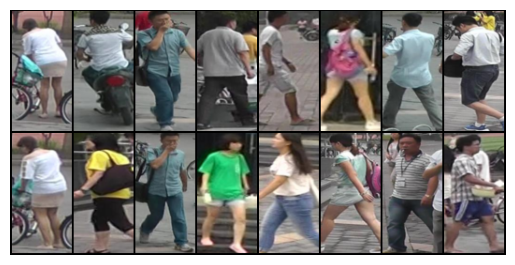

[1. 0. 1. 0. 0. 1. 1. 0.]


In [26]:
data_loader_vis= DataLoader(
    SNN_dataset_MARS(data, data_dir, train_ix), batch_size=8, shuffle=True, drop_last=True)
dataiter = iter(data_loader_vis)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [20]:
# same_hist = []
# for _,_, targets in data_loader_vis:
#     same_hist.append(targets.numpy())
# same_hist = np.array(same_hist).flatten()

In [21]:
# plt.hist(same_hist)
# plt.show()

In [12]:
batch_size = 128

train_dataset = SNN_dataset_MARS(data, data_dir, train_ix)
data_loader_train = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = SNN_dataset_MARS(data, data_dir, test_ix)
data_loader_test = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)


In [13]:
class SNN_classifier(nn.Module):
    def __init__(self):
        super(SNN_classifier, self).__init__()

        # Resnet18 is way more smaller than densenet121
        self.resnet18 = torchvision.models.resnet18(weights=None)
        # remove linear layer to use the fully connected NN
        self.resnet18 = torch.nn.Sequential(*(list(self.resnet18.children())[:-1]))

        # Resnet18 Linear layer input shape is 512
        self.fc = nn.Sequential(
            nn.Linear(512*2,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,1)
        )

        self.sigmoid = nn.Sigmoid()
    
    def forward_resnet18(self, x):
        y = self.resnet18(x)
        y = y.view(y.shape[0], -1)  # reshape to have shape(1,512)
        return y
    
    def forward(self, img1, img2_fv):
        # extract features vector for img1
        # img2_fv is a pre extracted features vector
        img1_fv = self.forward_resnet18(img1)

        x = torch.cat((img1_fv,img2_fv),axis=1)
        x = self.fc(x)
        
        y = self.sigmoid(x) # get probability

        return y

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
snn_classifier = SNN_classifier().to(device)

In [16]:
print(snn_classifier)

SNN_classifier(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [31]:
# transfer learning from training of Market-1501
snn_classifier.load_state_dict(torch.load(os.path.join('weights','model_final_default.pt'), map_location=device))

<All keys matched successfully>

In [32]:
criterion = nn.BCELoss()
lr = 1e-3
optimizer = torch.optim.Adam(snn_classifier.parameters(),lr=lr,weight_decay=1e-5)

In [33]:
optimizer.load_state_dict(torch.load(os.path.join('weights','opt_final.pt'), map_location=device))

In [34]:
train_loss = []
valid_loss = []

In [35]:
start_epoch = 500
n_epochs = start_epoch+500

In [36]:
smart_mkdir('weights')

False

In [ ]:
for epoch in range(start_epoch,n_epochs):

    epoch_train_loss = []
    snn_classifier.train()

    start = time.time()
    for batch_id, (imgs1, imgs2, targets) in enumerate(data_loader_train):

        imgs1, imgs2_fv, targets = imgs1.to(device), snn_classifier.forward_resnet18(
            imgs2.to(device)), targets.to(device)

        optimizer.zero_grad()

        output = snn_classifier(imgs1, imgs2_fv).squeeze(1)
        loss = criterion(output, targets)
        loss.backward()
        epoch_train_loss.append(loss.item())
        optimizer.step()
    
    train_loss.append(sum(epoch_train_loss)/len(epoch_train_loss))
    writer.add_scalar('Loss/train', train_loss[-1], epoch)

    epoch_valid_loss = []
    snn_classifier.eval()

    for batch_id, (imgs1, imgs2, targets) in enumerate(data_loader_test):
        
        imgs1, imgs2_fv, targets = imgs1.to(device), snn_classifier.forward_resnet18(
            imgs2.to(device)), targets.to(device)

        output = snn_classifier(imgs1, imgs2_fv).squeeze(1)
        loss = criterion(output, targets)
        epoch_valid_loss.append(loss.item())
    
    valid_loss.append(sum(epoch_valid_loss)/len(epoch_valid_loss))
    writer.add_scalar('Loss/validation', valid_loss[-1], epoch)
    
    print(f"Epoch {epoch} in {time.time()-start}: train loss={train_loss[-1]}, valid loss={valid_loss[-1]}")

    if ((epoch+1) % 10) == 0:
        print("Saving model")
        torch.save(snn_classifier.state_dict(),
                   os.path.join('weights', f"model_{epoch+1}.pt"))
        torch.save(optimizer.state_dict(),os.path.join('weights', f'opt_{epoch+1}.pt'))
        print("----------------------------")

torch.save(snn_classifier.state_dict(),
           os.path.join('weights', 'model_final.pt'))
torch.save(optimizer.state_dict(),os.path.join('weights', 'opt_final.pt'))


In [ ]:
plt.figure(figsize=(20, 10))

train_l = len(train_loss)
valid_l = len(valid_loss)

plt.plot(np.linspace(1, train_l, train_l).astype(
    int), train_loss, label="Training")

plt.plot(np.linspace(1, valid_l, valid_l).astype(
    int), valid_loss, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.savefig(os.path.join("training_mars.png"))

## Test section

In [17]:
snn_classifier.load_state_dict(torch.load(os.path.join('weights','model_final_mars.pt'), map_location=device))

<All keys matched successfully>

In [18]:
pred_test = np.array([])
true_test = np.array([])

In [19]:
indx = 0

for batch_id, (imgs1, imgs2, targets) in enumerate(data_loader_test):
        
        imgs1, imgs2_fv, targets = imgs1.to(device), snn_classifier.forward_resnet18(
            imgs2.to(device)), targets.to(device)

        output = snn_classifier(imgs1, imgs2_fv).squeeze(1)

        pred_test = np.concatenate((pred_test,output.detach().cpu().numpy().reshape(-1,)), axis=None)
        true_test = np.concatenate((true_test,targets.detach().cpu().numpy().reshape(-1,)), axis=None)

In [ ]:
metric = BinaryAccuracy()
average_precision = AveragePrecision(task="binary")
print(f"Classification accuracy: {metric(torch.tensor(pred_test), torch.tensor(true_test))}")
print(f"Classification average precision: {average_precision(torch.tensor(pred_test), torch.tensor(true_test.astype(int)))}")